# **Expected Goals Model (xG Model)**

**Introduction**

Results in football, more so than any other sport, can be greatly influenced by random moments and “luck.” Near misses, deflected shots, goalkeeping errors, and controversial refereeing decisions alone can dictate the final result. Football is a game of inches.

These effects are amplified by the fact that goals are rare events; a match produces 2.5 goals on average. Furthermore, a large majority of matches end in a draw or are decided by just a couple of goals, meaning a single goal can be largely significant to the result of a match.

This is where xG comes into play. xG measures the probability that a shot will result in a goal based on a number of factors. Such factors include the distance from where the shot was taken, angle with respect to the goal line, the game state (what is the score), if it was a header, if the shot came during a counter attack and other factors. For the purpose of simplicity, our exploration will focus on just three of these factors. We can use this metric to sum over all the chances in a match to determine how many goals a team should have scored based on the factors we aggregated in our model. We can go even further to apply this to a stretch of games, a season or even a manager’s tenure.

xG therefore can serve as a gauge of how potent a team is in attack and how solid they are on the back. It can also be used to analyze a players ability to create shooting opportunities in dangerous areas and how well he takes his chances. In summary, the xG model helps us eliminate a portion of the random factors associated with scoring opportunities when we attempt to quantify a team's ability to score goals, which in the end is the ultimate goal of football.

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tabulate import tabulate
from sklearn.metrics import f1_score

# Data Preprocessing

In [ ]:
#fileName = "events_England.json"
def shot_matrix(eventData):
  with open(eventData) as f:
    data = json.load(f)

  shots_dataset = pd.DataFrame(columns=['Goal','x','y','playerid','teamid','matchid','header'])
  event_df = pd.DataFrame(data)

  # Considering only shots from all sub events
  all_shots = event_df[event_df['subEventName']=='Shot']

  for index,shot in all_shots.iterrows():
    #fill in the columns for goals and headers with binary descripters
    shots_dataset.at[index,'Goal']=0
    shots_dataset.at[index,'header']=0
    for tag in shot['tags']:
        if tag['id']==101:
            shots_dataset.at[index,'Goal']=1
        elif tag['id']==403:
            shots_dataset.at[index,'header']=1
    
    #we are interested in distance from the goal as well as the angle formed with the goal
    #Dataset pitch has its origin at the top left of the pitch and is 100m x 100m
    #therefore x and y represent percentage of nearness to top left corner 
    #most pitches are 105 meters by 68 so we will go with that
    shots_dataset.at[index,'Y']= shot['positions'][0]['y']*.68
    shots_dataset.at[index,'X']= (100 - shot['positions'][0]['x'])*1.05

    #now we use dummy variables x and y to calc distance and angle attributes
    shots_dataset.at[index,'x']= 100 - shot['positions'][0]['x'] 
    shots_dataset.at[index,'y']=shot['positions'][0]['y']
    shots_dataset.at[index,'Center_dis']=abs(shot['positions'][0]['y']-50)
    
    x = shots_dataset.at[index,'x']*1.05
    y = shots_dataset.at[index,'Center_dis']*.68
    shots_dataset.at[index,'Distance'] = np.sqrt(x**2 + y**2)

    #angle made between the width of the goal and the
    #straight line distance to the shot location. A goal is 7.32 meters wide
    c=7.32
    a=np.sqrt((y-7.32/2)**2 + x**2)
    b=np.sqrt((y+7.32/2)**2 + x**2)
    k = (c**2-a**2-b**2)/(-2*a*b)
    gamma = np.arccos(k)
    if gamma<0:
        gamma = np.pi + gamma
    shots_dataset.at[index,'Angle Radians'] = gamma
    shots_dataset.at[index,'Angle Degrees'] = gamma*180/np.pi
    
    #adding the identifiers for player, team and match
    shots_dataset.at[index,'playerid']=shot['playerId']
    shots_dataset.at[index,'matchid']=shot['matchId']
    shots_dataset.at[index,'teamid']=shot['teamId']

  return shots_dataset

jsonfiles = ['events_England.json']

all_leagues = []
for file in jsonfiles:
    all_leagues.append(shot_matrix(file))
df_xG = pd.concat(all_leagues)

In [ ]:
df_xG.isnull().values.any()
df_xG.isnull().sum().sum()

0

In [ ]:
df_xG[df_xG.isnull().any(axis=1)]

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees


So it seems that there were some goals scored from the touch line which would require us to rethink how we created our construction of the angle attribute. Since there were only 3 occurences of such events and since they are normally unintentional rare events, I will remove them from our model. 

In [ ]:
df_xG.dropna()

,Goal,x,y,playerid,teamid,matchid,header,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
46,1,12,41,25413,1609,2499719,0,27.88,12.60,9.0,14.007655,0.467241,26.770923
62,0,15,52,26150,1631,2499719,0,35.36,15.75,2.0,15.808608,0.453557,25.986925
91,1,4,52,14763,1631,2499719,1,35.36,4.20,2.0,4.414703,1.375115,78.788301
128,0,19,33,7868,1609,2499719,0,22.44,19.95,17.0,23.057235,0.274666,15.737204
249,0,25,30,7868,1609,2499719,0,20.40,26.25,20.0,29.563872,0.219665,12.585866
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642945,0,28,45,8561,1633,2500098,0,30.60,29.40,5.0,29.595946,0.244517,14.009788
643023,1,14,33,41174,1633,2500098,0,22.44,14.70,17.0,18.700898,0.309646,17.741433
643051,0,12,62,7879,1623,2500098,0,42.16,12.60,12.0,15.011516,0.410444,23.516712
643055,0,8,38,145692,1623,2500098,0,25.84,8.40,12.0,11.710918,0.461143,26.421528


In [ ]:
df_xG.drop(columns = ['x','y','Center_dis'], axis=1, inplace=True)
df_xG

,Goal,playerid,teamid,matchid,header,Y,X,Distance,Angle Radians,Angle Degrees
46,1,25413,1609,2499719,0,27.88,12.60,14.007655,0.467241,26.770923
62,0,26150,1631,2499719,0,35.36,15.75,15.808608,0.453557,25.986925
91,1,14763,1631,2499719,1,35.36,4.20,4.414703,1.375115,78.788301
128,0,7868,1609,2499719,0,22.44,19.95,23.057235,0.274666,15.737204
249,0,7868,1609,2499719,0,20.40,26.25,29.563872,0.219665,12.585866
...,...,...,...,...,...,...,...,...,...,...
642945,0,8561,1633,2500098,0,30.60,29.40,29.595946,0.244517,14.009788
643023,1,41174,1633,2500098,0,22.44,14.70,18.700898,0.309646,17.741433
643051,0,7879,1623,2500098,0,42.16,12.60,15.011516,0.410444,23.516712
643055,0,145692,1623,2500098,0,25.84,8.40,11.710918,0.461143,26.421528


# Data Visualization

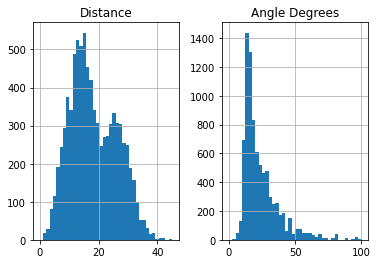

In [ ]:
fig, axes = plt.subplots(1, 2)
distance = df_xG.hist("Distance",bins=40,range = (0,45),ax= axes[0])
angles = df_xG.hist("Angle Degrees",bins=40, range = (0,100),ax=axes[1])

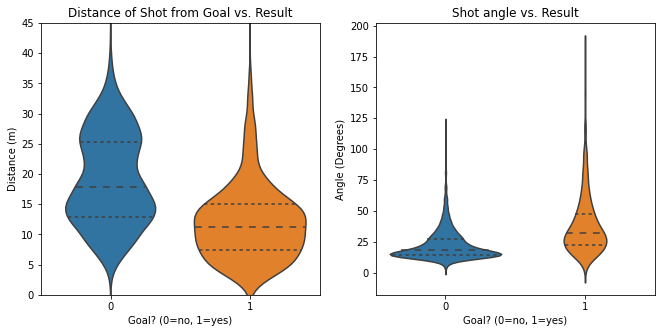

In [ ]:
#inspecting the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(1, 2,figsize=(11, 5))
shot_dist = sns.violinplot(x="Goal", y="Distance",
                    data=df_xG, inner="quart",ax= axes[0])
shot_dist.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Distance (m)",
       title="Distance of Shot from Goal vs. Result",ylim=(0, 45));
shot_ang = sns.violinplot(x="Goal", y="Angle Degrees",
                    data=df_xG, inner="quart",ax = axes[1])
shot_ang.set(xlabel="Goal? (0=no, 1=yes)",
       ylabel="Angle (Degrees)",
       title="Shot angle vs. Result");

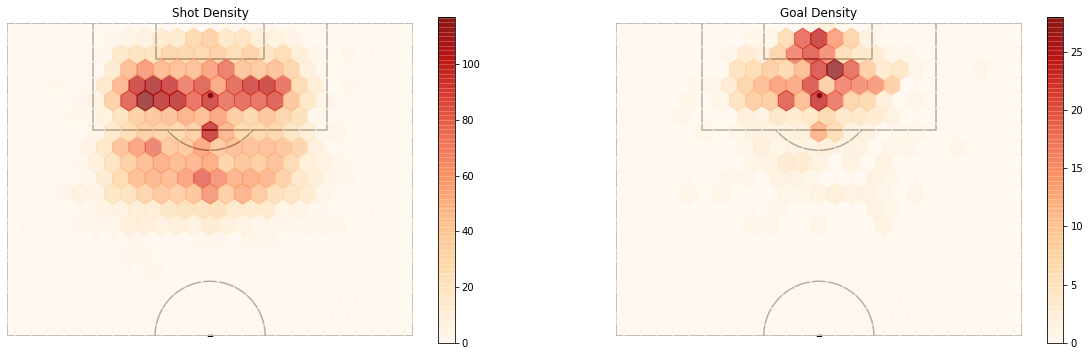

In [ ]:
from PitchPlot import draw_pitch
fig, ax = plt.subplots(1,2,figsize=(20, 6))
plt.sca(ax[0])
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax[0])

df_shots = df_xG[df_xG['header']==0]
plt.hexbin(data =df_shots, x='Y', y='X',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52))
ax[0].set_xlim(0, 68)
ax[0].set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax[0].set_title('Shot Density')

#now for the goals
plt.sca(ax[1])

df_goals = df_xG[(df_xG['Goal']==1) & (df_xG['header']==0)]
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax[1])
plt.hexbin(data = df_goals,x='Y', y='X',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52))
ax[1].set_xlim(0, 68)
ax[1].set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax[1].set_title('Goal Density')

plt.show()

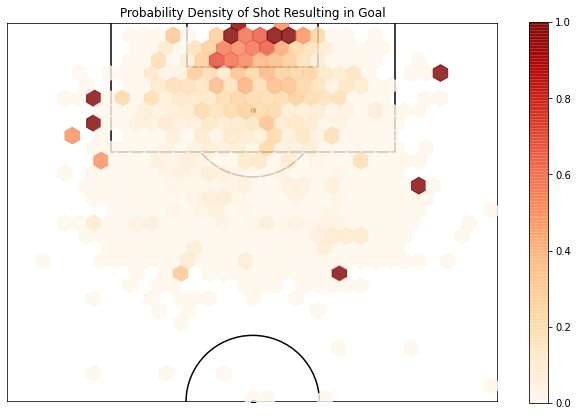

In [ ]:
#probabilty density of shot resulting in goals
df_shots =df_xG[df_xG['header']==0]
prob=np.array(df_shots['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
plt.hexbin(data = df_shots,x='Y', y='X',C=prob,reduce_C_function=np.mean,cmap='OrRd',gridsize=(34,15),
           alpha=.8,extent=(0,68,0,52))
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Probability Density of Shot Resulting in Goal')

plt.show()

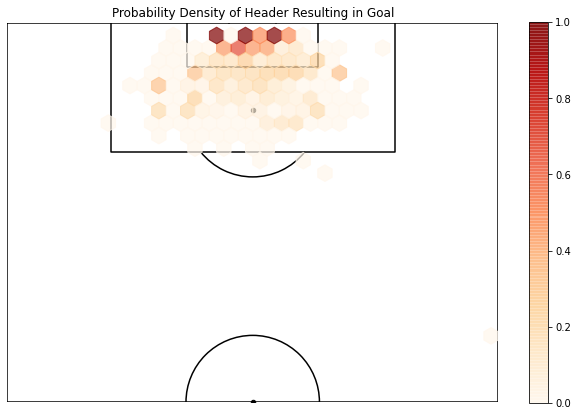

In [ ]:
#probabilty density of headers resulting in goals 
df_header = df_xG[df_xG['header']==1]
prob=np.array(df_header['Goal'])

fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
plt.hexbin(data = df_header,x='Y', y='X',C=prob,reduce_C_function=np.mean,cmap='OrRd',gridsize=(34,15),
           alpha=.7,extent=(0,68,0,52))
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Probability Density of Header Resulting in Goal')

plt.show()

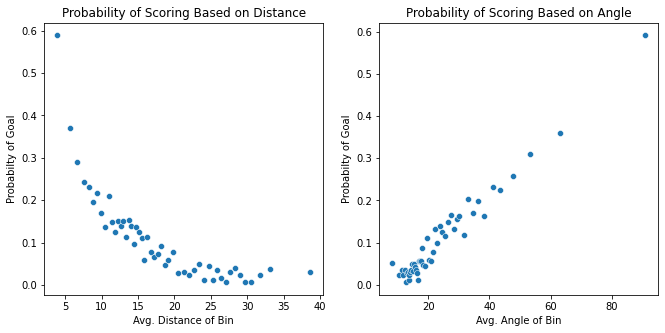

In [ ]:
fig, axes = plt.subplots(1, 2,figsize=(11, 5))
df_xG['Goal'] = df_xG['Goal'].astype(int)
df_xG['Distance_Bins'] = pd.qcut(df_xG['Distance'],q=50)

dist_prob = df_xG.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df_xG.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob,ax=axes[0])
dist_trend.set(xlabel="Avg. Distance of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")

df_xG['Angle_Bins'] = pd.qcut(df_xG['Angle Degrees'],q=50)
angle_prob = df_xG.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df_xG.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob,ax=axes[1])
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")


plt.show()

In [ ]:
df_xG['header'] = pd.to_numeric(df_xG['header'])
df_xG['Goal'] = pd.to_numeric(df_xG['Goal'])
df_xG

,Goal,playerid,teamid,matchid,header,Y,X,Distance,Angle Radians,Angle Degrees,Distance_Bins,Angle_Bins
46,1,25413,1609,2499719,0,27.88,12.60,14.007655,0.467241,26.770923,"(13.761, 14.173]","(26.702, 27.792]"
62,0,26150,1631,2499719,0,35.36,15.75,15.808608,0.453557,25.986925,"(15.617, 15.983]","(25.895, 26.702]"
91,1,14763,1631,2499719,1,35.36,4.20,4.414703,1.375115,78.788301,"(1.25, 5.004]","(69.258, 180.0]"
128,0,7868,1609,2499719,0,22.44,19.95,23.057235,0.274666,15.737204,"(22.311, 23.075]","(15.712, 15.985]"
249,0,7868,1609,2499719,0,20.40,26.25,29.563872,0.219665,12.585866,"(29.388, 30.129]","(12.408, 12.783]"
...,...,...,...,...,...,...,...,...,...,...,...,...
642945,0,8561,1633,2500098,0,30.60,29.40,29.595946,0.244517,14.009788,"(29.388, 30.129]","(13.932, 14.185]"
643023,1,41174,1633,2500098,0,22.44,14.70,18.700898,0.309646,17.741433,"(18.334, 18.912]","(17.306, 17.77]"
643051,0,7879,1623,2500098,0,42.16,12.60,15.011516,0.410444,23.516712,"(14.95, 15.392]","(23.144, 24.136]"
643055,0,145692,1623,2500098,0,25.84,8.40,11.710918,0.461143,26.421528,"(11.63, 12.04]","(25.895, 26.702]"


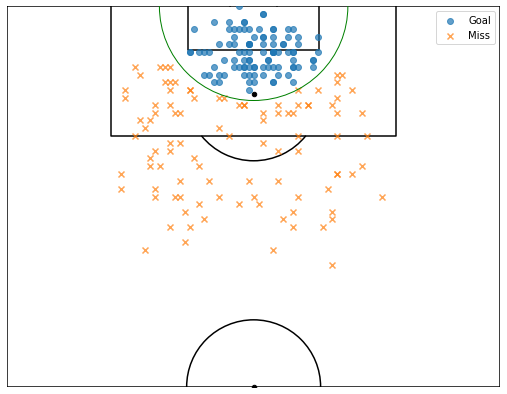

In [ ]:
#choose specific goals and misses
idx_goal = np.where((df_xG['Goal']==1) & (df_xG['Distance'] < 12)) 
df_HS_goal = df_xG.iloc[idx_goal]
idx_miss = np.where((df_xG['Goal']==0) & (df_xG['Distance']> 13)) 
df_HS_miss = df_xG.iloc[idx_miss]

#plot them with a bounday line between
prob=np.array(df_xG['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)
goals = plt.scatter(data = df_HS_goal.head(100),x='Y', y='X',alpha=.7)
misses = plt.scatter(data = df_HS_miss.head(100),x='Y', y='X',alpha=.7,marker='x')
ax.set_xlim(0,68)
plt.legend((goals,misses),('Goal','Miss'))
ax.set_ylim(52.5,0)
circle = plt.Circle((34,0),13,fill=False, color = 'Green')
ax.add_artist(circle)
plt.axis('off')

plt.show()

Above we can see that there is a clear distinction between the blue and orange clusters. If we assume this is the true nature of the relationship between shots and distance, and we want to predict future shot results based on this data, what model could we adopt?

Since the data is easily separable, we can draw a boundary line between the two clusters. This line will represent a discriminant function, which we will use to classify each shot outcome as a goal or miss. In the case above, the discriminant function maps out a distance r from the center of the goal.

Text(0.5, 1.0, 'Heaviside Function Classification for Shots')

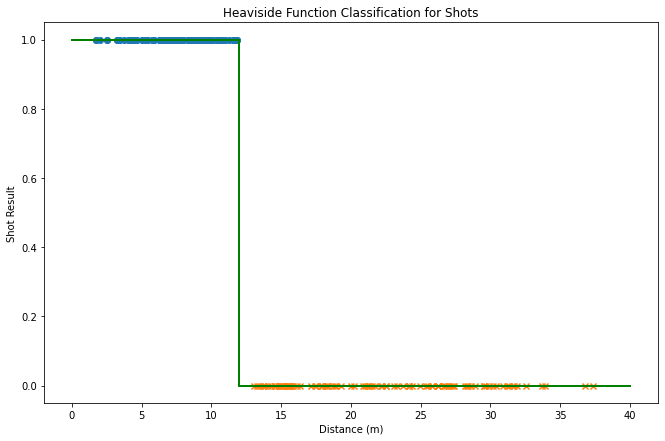

In [ ]:
#plot the heaviside function on top of the responses for the seperable data above
df_HS_predictor = np.append(df_HS_goal['Distance'].head(100), df_HS_miss['Distance'].head(100))
df_HS_response = np.append(df_HS_goal['Goal'].head(100), df_HS_miss['Goal'].head(100))

fig, axes = plt.subplots(figsize=(11,7))

goals = plt.scatter(df_HS_goal['Distance'].head(100),df_HS_goal['Goal'].head(100))
misses = plt.scatter(df_HS_miss['Distance'].head(100),df_HS_miss['Goal'].head(100),marker='x')
plt.plot([0,12], [1, 1], 'k-', lw=2,c='green')
plt.plot([12,12], [0, 1], 'k-', lw=2,c='green')
plt.plot([12,40], [0, 0], 'k-', lw=2,c='green')
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.title('Heaviside Function Classification for Shots')

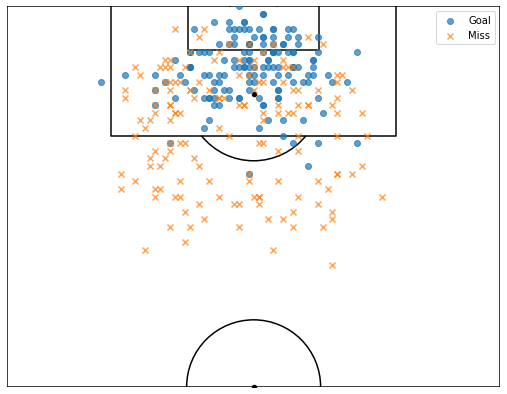

In [ ]:

# for a real representation of the data, let's try different characteristics

idx = np.where((df_xG['Goal']==1) & (df_xG['Distance'] < 25)) 
df_log_goal = df_xG.iloc[idx]
idx = np.where((df_xG['Goal']==0) & (df_xG['Distance']> 5)) 
df_log_miss = df_xG.iloc[idx]

prob=np.array(df_xG['Goal'])
fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)

goals = plt.scatter(data = df_log_goal.head(150),x='Y', y='X',alpha=.7)
misses = plt.scatter(data = df_log_miss.head(150),x='Y', y='X',alpha=.7,marker='x')
classifer = Arc(xy=(10,10),width=12,height=12)
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.legend((goals,misses),('Goal','Miss'))
plt.axis('off')


plt.show()

In [ ]:
#for now we are going to model just the distance predictor
from sklearn import metrics 
from sklearn.model_selection import train_test_split
train_dis = df_xG[['Goal','Distance']].copy()
x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), 
                                                    train_dis['Goal'], test_size=0.20, 
                                                    random_state=10)
from sklearn.linear_model import LogisticRegression
lgm_dis = LogisticRegression()
lgm_dis.fit(x_train_dis,y_train_dis)
log_odds = lgm_dis.coef_[0]
print(lgm_dis.coef_, lgm_dis.intercept_)
pd.DataFrame(log_odds, 
             x_train_dis.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

[[-0.14999942]] [0.124517]


,coef
Distance,-0.149999


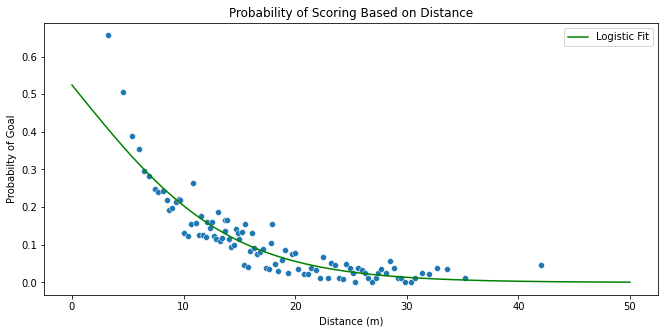

In [ ]:
fig, axes = plt.subplots(figsize=(11, 5))
df_xG['Goal']=df_xG['Goal'].astype(int)
df_xG['Distance_Bins'] = pd.qcut(df_xG['Distance'],q=100)
dist_prob = df_xG.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df_xG.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob)
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
dis = np.linspace(0,50,100)
sns.lineplot(x = dis,y = 1/(1+np.exp((0.146*dis-.097))),color='green',legend='auto',label='Logistic Fit')
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
df_dis_2 = df_xG[['Goal','Distance']].copy()
x_train_dis_2, x_test_dis_2, y_train_dis_2, y_test_dis_2 = train_test_split(df_dis_2.drop('Goal',axis=1), 
                                                    df_dis_2['Goal'], test_size=0.20, 
                                                    random_state=10)
poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lgm_dis_2 = LogisticRegression()
lgm_dis_2.fit(x_train_dis_2,y_train_dis_2)
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lgm_dis_2)])
pipe.fit(x_train_dis_2, y_train_dis_2)
print(lgm_dis_2.coef_,lgm_dis_2.intercept_)

[[-0.26741774  0.00368002]] [0.88759262]


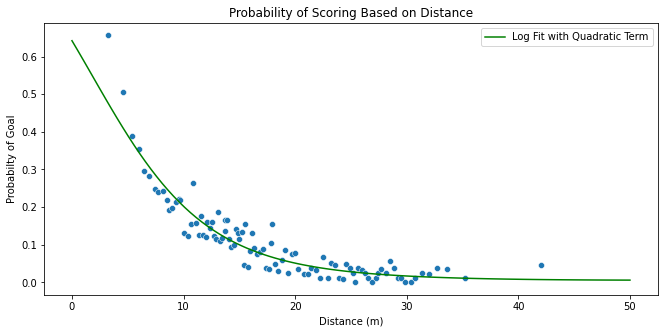

In [ ]:
fig, axes = plt.subplots(figsize=(11, 5))
df_xG['Goal']=df_xG['Goal'].astype(int)
df_xG['Distance_Bins'] = pd.qcut(df_xG['Distance'],q=100)
dist_prob = df_xG.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df_xG.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob)
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
dis = np.linspace(0,50,100)
sns.lineplot(x = dis,y = 1/(1+np.exp((0.21632621*dis-0.00206089*dis**2-0.58419379))),color='green',
             label='Log Fit with Quadratic Term')
plt.show()

If we add a quadratic term for the distance variable, we do a much better job at predicting shots close to goal.

In [ ]:
df_poly_ang = df_xG[['Goal','Angle Degrees']].copy()
X_train, X_test, Y_train, Y_test = train_test_split(df_poly_ang.drop('Goal',axis=1), 
                                                    df_poly_ang['Goal'], test_size=0.20, 
                                                    random_state=10)

poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lr_ang_poly = LogisticRegression()
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lr_ang_poly)])
pipe.fit(X_train, Y_train)

log_odds = lr_ang_poly.coef_[0]


print(lr_ang_poly.coef_,lr_ang_poly.intercept_)

[[ 0.08243744 -0.00034213]] [-4.14510699]


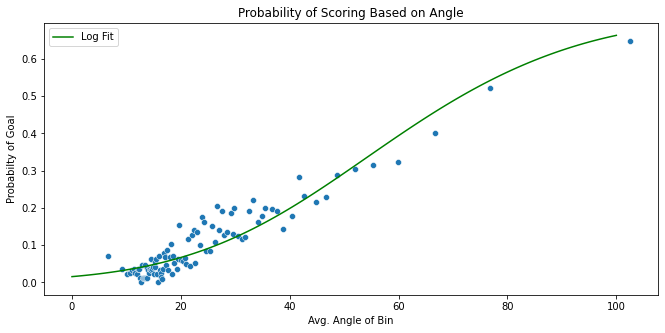

In [ ]:
#same for the angle
fig, axes = plt.subplots(figsize=(11, 5))
df_xG['Angle_Bins'] = pd.qcut(df_xG['Angle Degrees'],q=100)
angle_prob = df_xG.groupby('Angle_Bins',as_index=False)['Goal'].mean()['Goal']
angle_mean = df_xG.groupby('Angle_Bins',as_index=False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob)
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")
ang = np.linspace(0,100,100)
sns.lineplot(x = ang,y = 1/(1+np.exp(-(lr_ang_poly.coef_[0][0]*ang + lr_ang_poly.coef_[0][1]*ang**2
                                       + lr_ang_poly.intercept_[0]))),color='green',
             label='Log Fit')


plt.show()

In [ ]:
train_2 = df_xG[['Goal','Distance','Angle Radians']].copy()
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(train_2.drop('Goal',axis=1), 
                                                    train_2['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_2 = LogisticRegression(random_state=0)
lgm_2.fit(x_train_2,y_train_2)
log_odds = lgm_2.coef_[0]
print(lgm_2.coef_, lgm_2.intercept_)
print(pd.DataFrame(log_odds, 
             x_train_2.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False))

[[-0.09609732  1.22453868]] [-1.29537928]
                   coef
Angle Radians  1.224539
Distance      -0.096097


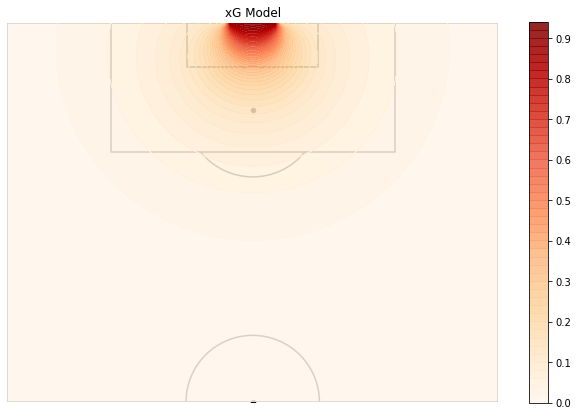

In [ ]:
def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
h_grid = Logistic(lgm_2.coef_[0][1]*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  +lgm_2.coef_[0][0]*np.sqrt((x1_grid)**2+(x0_grid)**2)+lgm_2.intercept_[0])


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contourf(x_0,x1, h_grid,alpha=.85,cmap='OrRd',levels=50)


plt.title('xG Model')

#plt.axis('off')
ax.set_xlim(0,68)
ax.set_ylim(52.5,0)
plt.colorbar()

(22.0, 0.0)

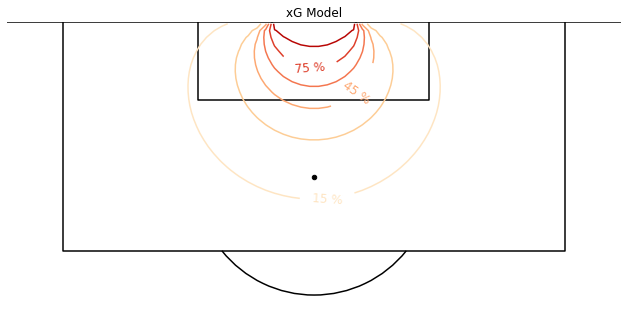

In [ ]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)


x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
h_grid = Logistic(1.57148079*np.arccos((c**2-a**2-b**2)/(-2*a*b))
                  -0.11023242*np.sqrt((x1_grid)**2+(x0_grid)**2)-1.02645936)


fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)


CS =plt.contour(x_0,x1, h_grid,alpha=1,cmap='OrRd',levels=7)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
plt.clabel(CS, CS.levels[1::2],inline=True, fmt=fmt, fontsize=12)

plt.title('xG Model')

#plt.axis('off')
ax.set_xlim(10,58)
ax.set_ylim(22,0)

(22.0, 0.0)

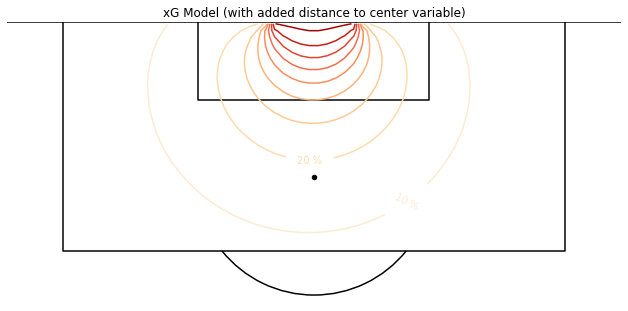

In [ ]:
#playing around with polynomials and variables to try to get better values for small angs
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
df_3 = df_xG[['Goal','Distance','Angle Radians','Y']].copy()
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_3.drop('Goal',axis=1), 
                                                    df_3['Goal'], test_size=0.20, 
                                                    random_state=10)
#ct = ColumnTransformer([('poly_X0X1', PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False), 
#                         ['Distance','Angle Radians']),
#                         ('poly_x0**2', FunctionTransformer(func=lambda x: x**2), ['Distance']),
#                         ('Y',FunctionTransformer(func=lambda x: x),['Y'])])

#poly_train = ct.fit_transform(X_train)
#poly_test = ct.fit_transform(X_test)


lgm_3 = LogisticRegression()

lgm_3.fit(x_train_3, y_train_3)

def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)

x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32
a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
ang = np.arccos((c**2-a**2-b**2)/(-2*a*b))
dis = np.sqrt((x1_grid)**2+(x0_grid)**2)
#h_grid_poly = Logistic(lr.coef_[0][0]*dis +lr.coef_[0][1]*ang + lr.coef_[0][2]*dis*ang +
#                       lr.coef_[0][3]*(ang**2)+lr.coef_[0][3]*x0_grid+lr.intercept_[0])

h_grid_Y = Logistic(lgm_3.coef_[0][0]*dis +lgm_3.coef_[0][1]*ang +lgm_3.coef_[0][2]*(x0_grid) +lgm_3.intercept_[0])


matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='white',
           line_color="black",
           ax=ax)



CS =plt.contour(x_0,x1, h_grid_Y,alpha=1,cmap='OrRd',levels=10)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
plt.clabel(CS, CS.levels[:3],inline=True, fmt=fmt, fontsize=10)

plt.title('xG Model (with added distance to center variable)')

plt.axis('off')
ax.set_xlim(10,58)
ax.set_ylim(22,0)

In [ ]:
df = df_xG.drop(columns=['Distance_Bins','Angle_Bins'])
df = df[["playerid", "teamid", "matchid", "header", "Y", "X", "Distance", "Angle Radians", "Angle Degrees", "Goal"]]
df

,playerid,teamid,matchid,header,Y,X,Distance,Angle Radians,Angle Degrees,Goal
46,25413,1609,2499719,0,27.88,12.60,14.007655,0.467241,26.770923,1
62,26150,1631,2499719,0,35.36,15.75,15.808608,0.453557,25.986925,0
91,14763,1631,2499719,1,35.36,4.20,4.414703,1.375115,78.788301,1
128,7868,1609,2499719,0,22.44,19.95,23.057235,0.274666,15.737204,0
249,7868,1609,2499719,0,20.40,26.25,29.563872,0.219665,12.585866,0
...,...,...,...,...,...,...,...,...,...,...
642945,8561,1633,2500098,0,30.60,29.40,29.595946,0.244517,14.009788,0
643023,41174,1633,2500098,0,22.44,14.70,18.700898,0.309646,17.741433,1
643051,7879,1623,2500098,0,42.16,12.60,15.011516,0.410444,23.516712,0
643055,145692,1623,2500098,0,25.84,8.40,11.710918,0.461143,26.421528,0


In [ ]:
from sklearn.model_selection import train_test_split

#df = np.asarray(df).astype(np.float32)
#data = tf.convert_to_tensor(df)

X_xG = df.iloc[:,:-1] 
y_xG = df.iloc[:,-1]
X_train_xG, X_test_xG, y_train_xG, y_test_xG = train_test_split(X_xG,y_xG,test_size= 0.2, random_state = 42)

In [ ]:
X_train_xG

,playerid,teamid,matchid,header,Y,X,Distance,Angle Radians,Angle Degrees
430346,127537,1628,2499973,0,24.48,21.00,23.057112,0.288355,16.521531
156926,8422,1628,2499813,0,29.24,14.70,15.451459,0.445480,25.524148
110953,7932,1639,2499786,0,47.60,26.25,29.563872,0.219665,12.585866
99224,9293,1659,2499779,0,23.12,12.60,16.647354,0.336416,19.275224
425987,32636,1623,2499970,0,36.04,23.10,23.189903,0.311936,17.872605
...,...,...,...,...,...,...,...,...,...
429686,38031,1628,2499973,0,31.28,13.65,13.918366,0.505984,28.990776
387830,8416,1651,2499948,0,46.24,11.55,16.829144,0.303647,17.397704
403808,7868,1612,2499957,0,42.84,23.10,24.733694,0.275411,15.779890
59246,28292,1644,2499755,0,34.00,22.05,22.050000,0.328973,18.848789


In [ ]:
#Grid Search for KNN
from sklearn.model_selection import GridSearchCV
p={'n_neighbors':np.arange(1,50), 'metric': ['euclidean', 'manhattan'], 'weights': ['uniform', 'distance']}
knn=KNeighborsClassifier()
x_knn=GridSearchCV(knn, p, cv=5, scoring='accuracy')
x_knn.fit(X_xG, y_xG)
results_knn = pd.DataFrame(x_knn.cv_results_)
results_knn[results_knn['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.012288,0.000129,0.066664,0.006559,euclidean,8,uniform,"{'metric': 'euclidean', 'n_neighbors': 8, 'wei...",0.89178,0.892899,0.891716,0.892899,0.892308,0.89232,0.000515,1


In [ ]:
#Grid Search for Decision Trees
from sklearn.tree import DecisionTreeClassifier

p = {'max_depth':np.arange(1,31), 'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random']}
des=DecisionTreeClassifier()
x_des=GridSearchCV(des, p, cv=5, scoring='accuracy')
x_des.fit(X_xG, y_xG)
results_des = pd.DataFrame(x_des.cv_results_)
results_des[results_des['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
65,0.006559,0.000264,0.001821,0.00005,gini,3,random,"{'criterion': 'gini', 'max_depth': 3, 'splitte...",0.895328,0.895858,0.895266,0.891124,0.898225,0.89516,0.002289,1


## Neural Network

In [ ]:
result = pd.DataFrame(columns=['Learning Rate', 'Transfer Function',  'Accuracy'])
lr = [0.00001, 0.0001, 0.001, 0.003, 0.01, 0.03, 1, 3, 10]
transfer_function = ['identity', 'logistic', 'tanh', 'relu']
k=0
for i in lr:
  for j in transfer_function:
    model = MLPClassifier(learning_rate_init= i, activation=j)
    model.fit(X_train_xG, y_train_xG)
    pred = model.predict(X_test_xG)
    result.loc[k] = [i, j,  accuracy_score(y_test_xG, pred)]
    k+=1
print(tabulate(result, headers=result.columns, tablefmt='grid'))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


+----+-----------------+---------------------+------------+
|    |   Learning Rate | Transfer Function   |   Accuracy |
+====+=================+=====================+============+
|  0 |          1e-05  | identity            |   0.109994 |
+----+-----------------+---------------------+------------+
|  1 |          1e-05  | logistic            |   0.892371 |
+----+-----------------+---------------------+------------+
|  2 |          1e-05  | tanh                |   0.892371 |
+----+-----------------+---------------------+------------+
|  3 |          1e-05  | relu                |   0.843288 |
+----+-----------------+---------------------+------------+
|  4 |          0.0001 | identity            |   0.892371 |
+----+-----------------+---------------------+------------+
|  5 |          0.0001 | logistic            |   0.892371 |
+----+-----------------+---------------------+------------+
|  6 |          0.0001 | tanh                |   0.892371 |
+----+-----------------+----------------

In [ ]:
model_NN = MLPClassifier(max_iter=800, learning_rate_init= 0.003, activation='relu')
model_NN.fit(X_train_xG, y_train_xG)
pred = model_NN.predict(X_test_xG)
accuracy_score(y_test_xG, pred)

0.8971023063276168

# Model Evaluation
If we want to assess the accuracy of our model, we have to test how well it can predict future events.


In order to make a classification, we have to define a threshold. This threshold essentially splits the logistic function, assigning goals for where the model lies above the threshold and misses below

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

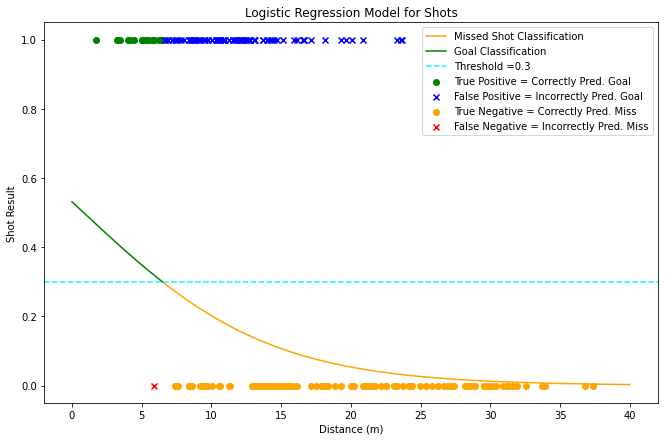

In [ ]:
#plot the heaviside function on top of the responses for the seperable data above
threshold=0.3
threshold_x=6.5
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')

[[1450   39]
 [ 166   36]]


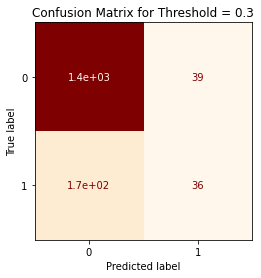

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
threshold=[0.3]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_3 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_3,display_labels=np.arange(25)).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.3')
print(cm_dis_3)

The model does a fantastic job of predicting misses but a poor job of predicting goals, and this is understandable if we examine where the threshold intersects the model.

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

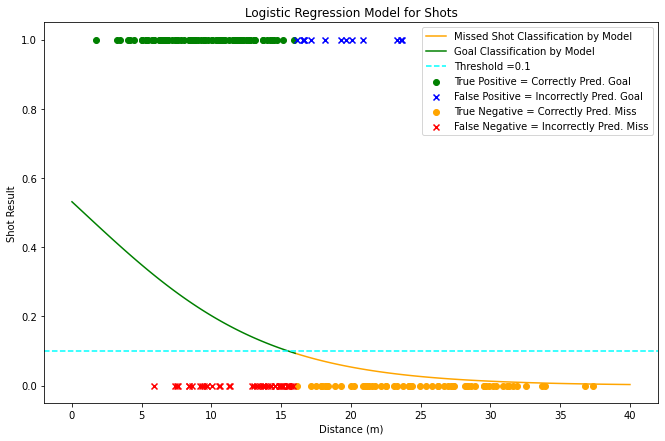

In [ ]:
threshold=0.1
threshold_x=16
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification by Model')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification by Model')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')

[[917 572]
 [ 44 158]]


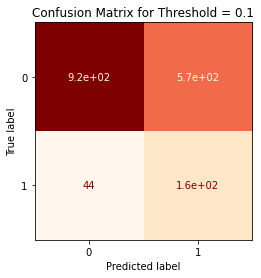

In [ ]:
threshold=[0.1]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_10 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_10,display_labels=np.arange(25)).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.1')
print(cm_dis_10)

In [ ]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_10 = cm_dis_10[1][1]/(cm_dis_10[1][1]+cm_dis_10[1][0])
print('sensitivity = ' + str(sensitivity_10))
#the ability of the model to correctly identify shots that did not result in a goal
specificity_10 = cm_dis_10[0][0]/(cm_dis_10[0][0]+cm_dis_10[0][1])
print('specificity = '+ str(specificity_10) )
print(cm_dis_10[0][1])

sensitivity = 0.7821782178217822
specificity = 0.615849563465413
572


Now we have the opposite effect. The logistic regression model produces a better classification of goals but misclassifies misses at a much high volume. If we split the difference and choose a threshold in between the previous two:

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

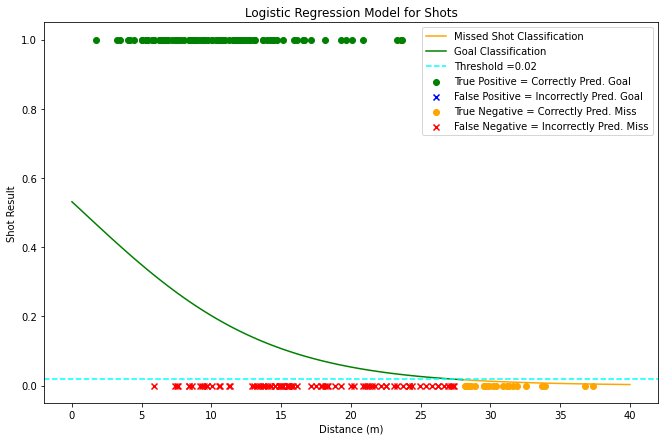

In [ ]:
threshold=0.02
threshold_x=28
df_goal = df_log_goal[:100]
df_miss = df_log_miss[:100]
TP = df_goal[df_goal['Distance']<threshold_x]
TN = df_miss[df_miss['Distance']>threshold_x]
FP = df_goal[df_goal['Distance']>threshold_x]
FN = df_miss[df_miss['Distance']<threshold_x]

fig, axes = plt.subplots(figsize=(11,7))
TP_scatter = plt.scatter(TP['Distance'],TP['Goal'],c='Green',label='True Positive = Correctly Pred. Goal')
FP_scatter = plt.scatter(FP['Distance'],FP['Goal'],c='blue',label='False Positive = Incorrectly Pred. Goal',marker='x')
TN_scatter = plt.scatter(TN['Distance'],TN['Goal'],c='orange',label='True Negative = Correctly Pred. Miss')
FN_scatter = plt.scatter(FN['Distance'],FN['Goal'],c='red',label='False Negative = Incorrectly Pred. Miss',marker='x')

#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
y = np.linspace(threshold_x,40,100)
y_2 =np.linspace(0,threshold_x,100)

plt.plot(y,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y+lgm_dis.intercept_[0]))),c='orange',label='Missed Shot Classification')
plt.plot(y_2,1/(1+np.exp(-(lgm_dis.coef_[0][0]*y_2+lgm_dis.intercept_[0]))),c='green',label='Goal Classification')
plt.axhline(y=threshold, color='cyan', linestyle='dashed',label='Threshold ='+str(threshold))
plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')

[[ 266 1223]
 [   7  195]]


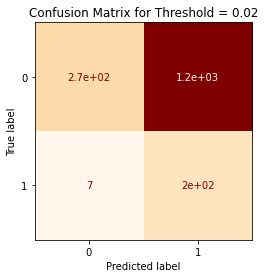

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
threshold=[0.02]
y_pred = (lgm_dis.predict_proba(x_test_dis)[:, 1] > threshold).astype('float')
cm_dis_02 = confusion_matrix(y_test_dis, y_pred)
cm_display = ConfusionMatrixDisplay(cm_dis_02,display_labels=np.arange(25)).plot(cmap='OrRd')
cm_display.im_.colorbar.remove()
plt.title('Confusion Matrix for Threshold = 0.02')
print(cm_dis_02)

In [ ]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_02 = cm_dis_02[1][1]/(cm_dis_02[1][1]+cm_dis_02[1][0])
print('sensitivity = ' + str(sensitivity_02))
#the ability of the model to correctly identify shots that did not result in a goal
specificity_02 = cm_dis_02[0][0]/(cm_dis_02[0][0]+cm_dis_02[0][1])
print('specificity = '+ str(specificity_02) )
print(cm_dis_02[0][1])

sensitivity = 0.9653465346534653
specificity = 0.1786433848220282
1223


We now predict goals and misses at a more balanced rate. We have seen that three different thresholds produce vastly different predictions from our model. Where they vary is in their specificity and sensitivity; that is, their ability to correctly predict goals and misses.

In [ ]:
#sensitivity = the ability of the model to correctly identify shots that resulted in a goal.
sensitivity_3 = cm_dis_3[1][1]/(cm_dis_3[1][1]+cm_dis_3[1][0])
#the ability of the model to correctly identify shots that did not result in a goal
specificity_3 = cm_dis_3[0][0]/(cm_dis_3[0][1]+cm_dis_3[0][0])

Text(0.5, 1.0, 'ROC Graph')

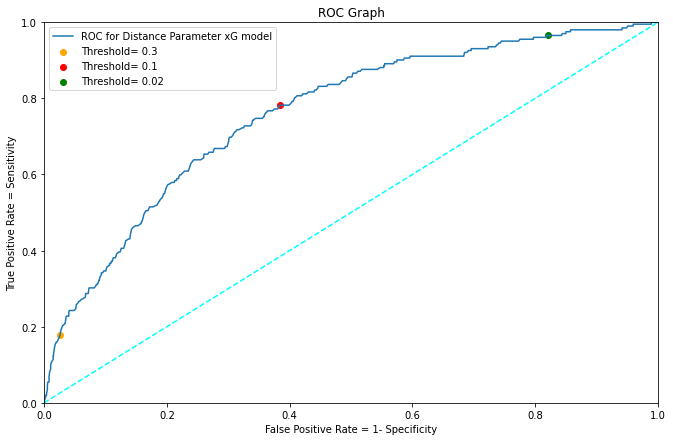

In [ ]:
from sklearn.metrics import roc_curve
fig, axes = plt.subplots(figsize=(11,7))
y_score = lgm_dis.decision_function(x_test_dis)
fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
plt.plot(fpr,tpr,label='ROC for Distance Parameter xG model')

plt.scatter(1-specificity_3,sensitivity_3,c='orange',label='Threshold= 0.3')
plt.scatter(1-specificity_10,sensitivity_10,c='red',label='Threshold= 0.1')
plt.scatter(1-specificity_02,sensitivity_02,c='green',label='Threshold= 0.02')
y_45 = np.linspace(0,1,100) 
plt.plot(y_45,y_45,linestyle='dashed',c='cyan')
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate = 1- Specificity')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Graph')

[[-0.09637508  1.22564995 -0.00417512]] [-1.15265924]
[[-0.11480867  1.34515634 -0.9117081 ]] [-0.89537516]


Text(0.5, 1.0, 'ROC Graph')

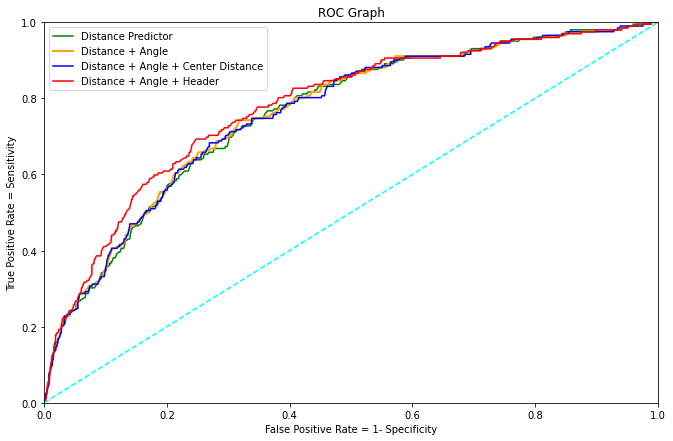

In [ ]:
train_3 = df_xG[['Goal','Distance','Angle Radians','Y']].copy()
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(train_3.drop('Goal',axis=1), 
                                                    train_3['Goal'], test_size=0.20, 
                                                    random_state=10)

lgm_3 = LogisticRegression()
lgm_3.fit(x_train_3,y_train_3)
log_odds = lgm_3.coef_[0]
print(lgm_3.coef_, lgm_3.intercept_)


train_4 = df[['Goal','Distance','Angle Radians','header']].copy()
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(train_4.drop('Goal',axis=1), 
                                                    train_4['Goal'], test_size=0.20, 
                                                    random_state=10)

lgm_4 = LogisticRegression()
lgm_4.fit(x_train_4,y_train_4)
log_odds = lgm_4.coef_[0]
print(lgm_4.coef_, lgm_4.intercept_)

fig, axes = plt.subplots(figsize=(11,7))
y_score = lgm_dis.decision_function(x_test_dis)
fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
plt.plot(fpr,tpr,label='Distance Predictor',c='green')

y_score_2 = lgm_2.decision_function(x_test_2)
fpr2, tpr2, _  = roc_curve(y_test_2,y_score_2, pos_label=lgm_2.classes_[1])
plt.plot(fpr2,tpr2,label='Distance + Angle',c='orange',linewidth=2)

y_score_3 = lgm_3.decision_function(x_test_3)
fpr_3, tpr_3, _  = roc_curve(y_test_3,y_score_3, pos_label=lgm_3.classes_[1])
plt.plot(fpr_3,tpr_3,label='Distance + Angle + Center Distance',c='blue')

y_score_4 = lgm_4.decision_function(x_test_4)
fpr_4, tpr_4, _  = roc_curve(y_test_4,y_score_4, pos_label=lgm_4.classes_[1])
plt.plot(fpr_4,tpr_4,label='Distance + Angle + Header',c='red')
plt.legend()

y_45 = np.linspace(0,1,100) 
plt.plot(y_45,y_45,linestyle='dashed',c='cyan')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate = 1- Specificity')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Graph')

A model with distance and angle as input variables produces the same area under the curve (AUC) as the same model but with an added “distance to center” parameter. So, contrary to some of the assumptions we made earlier, the “distance to center”predictor does not add much to the performance of our model and we should exclude it. While the “distance to center” parameter showed a slight change to the model in areas close to the goal line, this change meant very little as so few shots are taken from those positions. The AUC therefore tells us that adding the center to distance variable is rather useless.

In [ ]:
classifiers = [lgm_4, 
               KNeighborsClassifier(8, 'uniform', metric='euclidean'), 
               MultinomialNB(), 
               DecisionTreeClassifier('gini', 'best', 3),
               MLPClassifier(max_iter=1000, learning_rate_init= 0.003, activation='relu')
               ]
classifier_names = ["Logistic", 
                    "kNN Classifier",
                    "Naive Bayes Classifier", 
                    "Decision Tree Classifier", 
                    "Neural Network"
                    ]
accuracies = []

In [ ]:
train_5 = df[['Goal','Distance','Angle Radians','header']].copy()
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(train_5.drop('Goal',axis=1), 
                                                    train_5['Goal'], test_size=0.20, 
                                                    random_state=10)
lgm_5 = LogisticRegression(fit_intercept=False, solver='lbfgs')
lgm_5.fit(x_train_5,y_train_5)
X = x_train_4
from numpy.random import binomial, normal
from scipy.stats import bernoulli, binom
np.random.seed(37)

def full_log_likelihood(w, X, y):
    score = np.dot(X, w).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def null_log_likelihood(w, X, y):
    z = np.array([w if i == 0 else 0.0 for i, w in enumerate(w.reshape(1, X.shape[1])[0])]).reshape(X.shape[1], 1)
    score = np.dot(X, z).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

w = np.array(lgm_4.coef_).transpose()
y_pred = lgm_5.predict_proba(X)[:, 1]
n = 6760
z = np.dot(X, np.array([1.0, 2.0, 3.0])) + normal(0.0, 1.0, n)
p = 1.0 / (1.0 + np.exp(-z))
y = binom.rvs(1, p)

def mcfadden_rsquare(w, X, y):
    return 1.0 - (full_log_likelihood(w, X, y) / null_log_likelihood(w, X, y))

def mcfadden_adjusted_rsquare(w, X, y):
    k = float(X.shape[1])
    return 1.0 - ((full_log_likelihood(w, X, y) - k) / null_log_likelihood(w, X, y)) 
print(mcfadden_adjusted_rsquare(w,X,y))

0.1437583348025432


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

scores=pd.DataFrame(columns=['Model','Training Accuracy Score', 'Test Accuracy Score'])

pipe_log=Pipeline(steps=[('Logistic', LogisticRegression())])
pipe_knn=Pipeline(steps=[('KNN', KNeighborsClassifier(8, 'uniform', metric='euclidean'))])
pipe_nb=Pipeline(steps=[('NB', MultinomialNB())])
pipe_dt=Pipeline(steps=[('Decision Tree', DecisionTreeClassifier('gini', 'best', 3))])
pipe_nn=Pipeline(steps=[('Neural Network', MLPClassifier(max_iter=800, learning_rate_init= 0.003, activation='relu'))])

pipe=[pipe_log, pipe_knn, pipe_nb, pipe_dt, pipe_nn]
mo=['Logistic Regression', 'KNN Classifier', 'Naive Bayes', 'Decision Tree Classifier', 'Neural Network']
j=0

for i in pipe:
  x_pip=i.fit(X_train_xG, y_train_xG)
  tra=accuracy_score(x_pip.predict(X_train_xG), y_train_xG)
  tea=accuracy_score(x_pip.predict(X_test_xG), y_test_xG)
  scores.loc[j]=[mo[j],tra, tea]
  j+=1

scores

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Model,Training Accuracy Score,Test Accuracy Score
0,Logistic Regression,0.891716,0.892371
1,KNN Classifier,0.892899,0.892371
2,Naive Bayes,0.303994,0.321703
3,Decision Tree Classifier,0.896450,0.898285
4,Neural Network,0.127071,0.130692


We need to remember that every shot is unique, comprised of hundreds of different variables that we have tried to model using just three. For that we should not expect to predict goals with certainty or anywhere near it. Some of this is due to our inability to model all these variables. Consider that while distance and angle give us a good sense of the likelihood of shot resulting in a goal, we did not take into account where the goalkeeper is positioned, if the shot was taken with a weak foot or strong foot, shot height at point of contact, the game state, home field advantage, if there are many bodies between the goal and the shot, etc. These are just a handful of the quantifiable variables that have an influence. There are also variables that are not easily quantifiable: what is the state of the pitch (as in rugged or is it a carpet), is fatigue playing a role, morale and confidence, and other soft factors. Even after neglecting these other variables, there is also some level of intrinsic randomness to shots.